<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the project:
---
Named Entity Recognition (NER): map words to different types (tags)

# Load the dataset:

In [18]:
# install libraries:
!pip install transformers datasets
# `transformers` library: for working with pre-trained NLP models
# `datasets` library: for working with datasets

In [19]:
# from `datasets` library, import the `load_dataset` func for downloading datasets
from datasets import load_dataset

In [20]:
# use the `load_dataset` func to load the CoNLL-2003 dataset (a popular benchmark dataset for NER consists of English news articles):
data = load_dataset("conll2003")

In [21]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [22]:
# check features (cols) of the train data:
data["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [23]:
# check a specific feature:
data["train"].features['ner_tags']

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [24]:
# check different types of named entities & save the tags for later:
label_names = data["train"].features['ner_tags'].feature.names

# Load the tokenizer:

In [25]:
from transformers import AutoTokenizer # import the 'AutoTokenizer' class from the HF transformers library
# `AutoTokenizer` class: automatically load the appropriate tokenizer for a specific pre-trained model

checkpoint = "distilbert-base-cased" # model identifier (specify the name of a pre-trained model)
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # automatically load the appropriate tokenizer

# The input:

In [26]:
# check the 1st row in the training split of the dataset:
data["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [27]:
# tokenize the 'tokens' feature of the 1st row in the training split of the dataset:
idx = 0
t = tokenizer(data["train"][idx]["tokens"], is_split_into_words=True)
# `is_split_into_words=True`: string input -> a list of words (string tokens) -> tokenize each word into a numeric token
t

{'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

👆 The attention_mask is a binary mask that indicates which tokens in a sequence should be attended to (considered) and which should be ignored during processing.

The primary purpose of the attention_mask is to handle variable-length sequences. In a batch of sequences, not all sequences are likely to have the same length. The attention_mask allows the model to focus on the actual content of the sequence and ignore the padding tokens.

In many tokenization scenarios, padding tokens are added to the sequences to make them of equal length.

In [28]:
type(t)

transformers.tokenization_utils_base.BatchEncoding

👆 The tokenized output is a BatchEncoding object (a dictionary with specific keys).

In [29]:
# get string tokens:
t.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

👆 The word "lamb" has been split into ***2 subwords*** ('la' + '##mb').

But we are provided with ***1 target*** for the whole word.

Therefore, the input sequence may end up being longer than the target sequence!

Solution: ***For any word split into multiple string tokens, we assign the same target***. Eg: 'la' -> 7, '##mb' -> 7

# Align string tokens (subwords) to targets correctly:

eg:
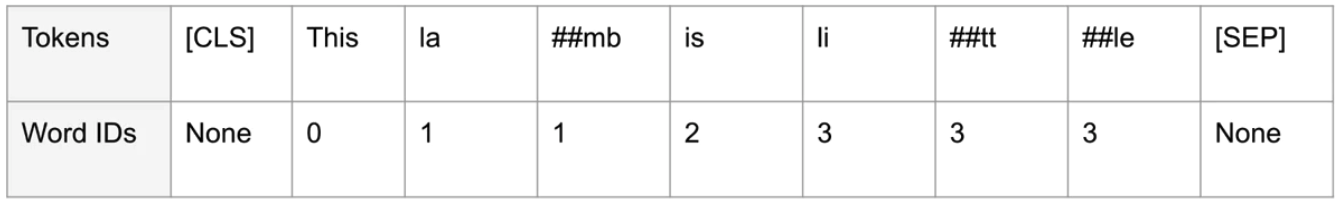

In [30]:
# word_id (i) indicates it is the i-th word in the input sentence (counting from 0):
t.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

👆 The targets are None for [CLS] and [SEP] tokens. And 8 responses to the period.

In [33]:
#['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
begin2inside = {
  1: 2, # 'B-PER', 'I-PER' (label 1 map to label 2)
  3: 4, # 'B-ORG', 'I-ORG' (label 3 map to label 4)
  5: 6, # 'B-LOC', 'I-LOC'
  7: 8, # 'B-MISC','I-MISC'
}

👆 This takes care of 4 types of entities (PER, ORG, LOC, MISC).

In [34]:
def align_targets(labels, word_ids):
  aligned_labels = []
  last_id = None
  for id in word_ids:
    if id is None: # [CLS] or [SEP]
      label = -100
    elif id != last_id: # it's a new id (new word)
      label = labels[id]
    else: # it's the same word as before
      label = labels[id]
      if label in begin2inside: # B-tag
        label = begin2inside[label] # B-tag -> I-tag

    aligned_labels.append(label)
    last_id = id # update last_id

  return aligned_labels # eg: [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]

In [35]:
# idx = 0  # defined earlier
data['train'][idx]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [36]:
labels = data['train'][idx]['ner_tags'] # [3, 0, 7, 0, 0, 0, 7, 0, 0]
word_ids = t.word_ids() # [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

# call the 'align_targets' function:
aligned_targets = align_targets(labels, word_ids)
aligned_targets

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]